In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import smplotlib
from numpy.random import *
import secrets

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import time

In [2]:
seed = secrets.randbits(128)
rng_default = np.random.default_rng(seed)

### 1) Extend the program of the 3rd assignment to include the generation of velocities.
### 2) Use the phase space distribution function of the Plummer model to find the local velocity distribution at a given radial position.
### 3) Use it to draw random speeds for each particle.
### 4) Use the routine that generates random positions in the unit sphere to convert speeds in velocities.
### 5) Compute the total kinetic and potential energies of the final random realization and verify the the virial ratio (2K/|W|) is one.

In [123]:
def delta_P(eta):
    return np.power(1.0+np.square(eta), -2.5)

def mu_P(eta):
    return np.power(eta, 3) * np.power((1.0+np.square(eta)), -1.5)

def mu_P_inv(mu_):
    mup = np.power(mu_, 2.0/3.0)
    return np.sqrt(mup/((1.0-np.sqrt(mup))*(1.0+np.sqrt(mup))))

def RandomPlummer_r(N, rng=rng_default):
    mu_P_ = rng.random(N)
    return mu_P_inv(mu_P_)

def Random_sphere(N, rng=rng_default):
    z = rng.uniform(-1.0, 1.0, N)
    ph = rng.uniform(0.0, 2*np.pi, N)
    sth = np.sqrt((1.0 - z) * (1.0 + z))
    x = sth * np.cos(ph)
    y = sth * np.sin(ph)
    return np.array([x, y, z]).transpose()

def RandomPlummer(N, rng=rng_default):
    Rp_r = RandomPlummer_r(N, rng).reshape((N, 1))
    result = Random_sphere(N, rng)
    return result * Rp_r

def RandomPlummerCart(N, rng=rng_default):
    Points = RandomPlummer(N, rng)
    r_ = Points[:,0]
    th_ = Points[:,1]
    ph_ = Points[:,2]

    x = r_ * np.sin(th_) * np.cos(ph_)
    y = r_ * np.sin(th_) * np.sin(ph_)
    z = r_ * np.cos(th_)
    return np.array([x, y, z]).transpose()

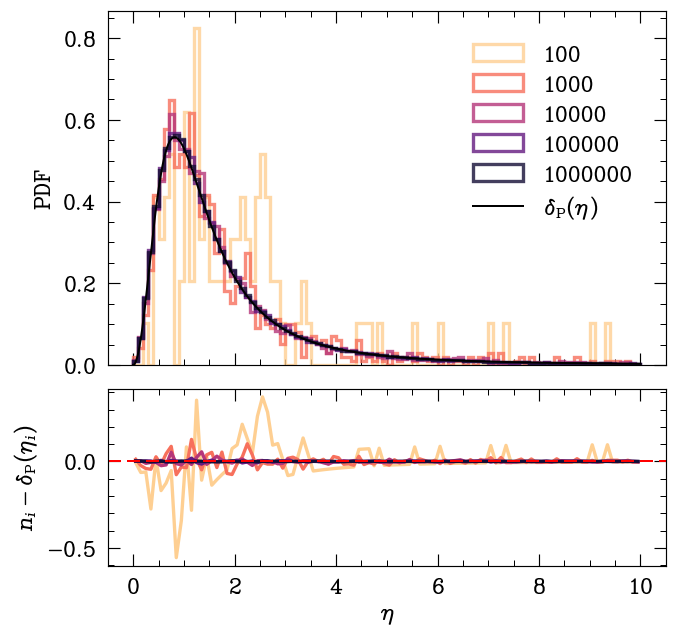

In [132]:
eta = np.linspace(0.0, 10.0, 1000)
mu_P_ = np.linspace(0.0, 1.0, 1000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

N = np.geomspace(100, 1e6, 5, dtype=np.int32)
nbins = 100

cmap = mpl.cm.get_cmap('magma_r')
colors = cmap(np.linspace(0.1, 0.9, len(N)))

for i, Ni in enumerate(N):
    etai = RandomPlummer_r(Ni)
    #etai = RandomPlummerPhaseSpace(Ni)
    ni, bins = np.histogram(etai, bins=nbins, range=(0, np.max(eta)))
    bins_centered = 0.5*(bins[:-1] + bins[1:])
    FracDiff = ni / (Ni * np.diff(bins)) - bins_centered**2*delta_P(bins_centered)*3
    
    ax1.hist(etai, bins=nbins, range=(0, np.max(eta)), color=colors[i], density=True, label=str(Ni), alpha=0.8, histtype='step', lw=2)
    ax2.plot(bins_centered, FracDiff, color=colors[i], lw=2)

ax1.plot(eta, eta**2*delta_P(eta)*3, label=r'$\delta_{\rm P}(\eta)$')
ax1.set_ylabel(r'PDF')
ax1.legend()
ax2.set_ylabel(r'$n_i - \delta_{\rm P}(\eta_i)$')
ax2.axhline(0.0, c='r', ls='--')
ax2.set_xlabel(r'$\eta$')

plt.subplots_adjust(hspace=0.09)

In [98]:
eta = np.linspace(0, 100, 1000)
np.trapz(eta**2*delta_P(eta)/DD, eta), np.trapz(eta**2*delta_P(eta)*3, eta)

(1.0950357159266073, 0.9998500186726939)

#### The Plummer model revisited

\begin{equation}
    f_{\rm P}(E) = f_0 |E|^{7/2}, ~ ~ E<0,
\end{equation}
where
\begin{equation}
    f_0 = \frac{3\sqrt{2^7}}{7\pi^3G^5} \left( \frac{r_0}{M^2} \right)^2,
\end{equation}

From $f(E)$, we can compute the local velocity distribution:
\begin{equation}
    f(v,r) = Av^2 [ B(r) - v^2/2]^{7/2},
\end{equation}
where,
\begin{equation}
    A=4\pi f_0, ~~~B(r)=GM/\sqrt{r^2+r_0^2}.
\end{equation}

In [224]:
f_0 = 3*np.sqrt(2**7)/(7*np.pi**3)
A = 4*np.pi*f_0

def B(eta):
    return 1.0/np.sqrt(np.square(eta)+1.0)

def v_esc(eta):
    return np.sqrt(2*B(eta))

def f(v, eta):
    return A*np.square(v)*np.power(B(eta)-0.5*np.square(v), 3.5)

def v_star(eta):
    return 2.0/3.0 * np.sqrt(B(eta))

def f_max(eta):
    return f(v_star(eta), eta)

def f_P(E):
    return f_0*np.abs(E)**3.5

In [225]:
def Random_v(eta, N, rng=rng_default):
    v = rng.uniform(0.0, v_esc(eta), N)
    f_ = rng.uniform(0.0, f_max(eta), N)
    vv = v[f_ < f(v, eta)]
    while len(vv) < N:
        v = rng.uniform(0.0, v_esc(eta), N)
        f_ = rng.uniform(0.0, f_max(eta), N)
        vv = np.concatenate((vv, v[f_ < f(v, eta)]))
    return vv[:N]

def Random_v_single(eta, rng=rng_default):
    v = rng.uniform(0.0, v_esc(eta))
    f_ = rng.uniform(0.0, f_max(eta))
    while f_ > f(v, eta):
        v = rng.uniform(0.0, v_esc(eta))
        f_ = rng.uniform(0.0, f_max(eta))
    return v

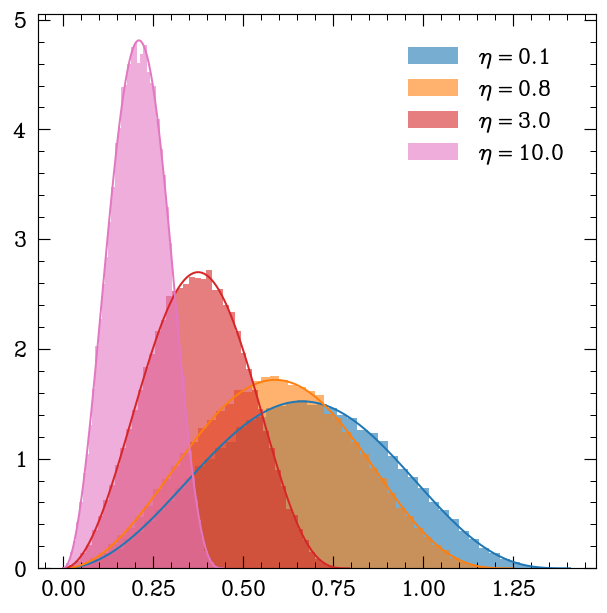

In [226]:
eta = [0.1, 0.8, 3.0, 10.0]
N = 100000
nbins = 50
cmap = mpl.cm.get_cmap('tab10')
colors = cmap(np.linspace(0, 0.6, len(eta)))

fig, ax = plt.subplots()

for i, eta_ in enumerate(eta):
    v = np.linspace(0.0, v_esc(eta_)/1.001, 100)
    v_ = Random_v(eta_, N)
    FF = np.trapz(f(v, eta_), v)
    ax.plot(v, f(v, eta_)/FF, c=colors[i])
    ax.hist(v_, bins=nbins, range=(0, v_esc(eta_)), density=True, alpha=0.6, color=colors[i], label=r'$\eta=$'+str(eta_))
ax.legend()

In [219]:
def RandomPlummerPhaseSpace(N, rng=rng_default):
    xyz = RandomPlummer(N, rng=rng)
    r = np.sqrt(np.square(xyz[:,0]) + np.square(xyz[:,1]) + np.square(xyz[:,2]))
    v = np.zeros_like(r)
    for j, r_ in enumerate(r):
        v[j] = Random_v_single(r_, rng=rng)
    u = Random_sphere(N, rng=rng)
    return xyz, u*v.reshape(N, 1)

In [220]:
def K(v):
    v2 = np.square(v[:,0]) + np.square(v[:,1]) + np.square(v[:,2])
    return 0.5*np.sum(v2)

def Kv(v):
    return 0.5*np.sum(v*v)

def W(xyz):
    r2 = np.square(xyz[:,0]) + np.square(xyz[:,1]) + np.square(xyz[:,2])
    return np.sum(-1.0/np.sqrt(1.0+r2))

def Wr(r):
    return np.sum(-1.0/np.sqrt(1.0+r*r))

In [221]:
xyz, v = RandomPlummerPhaseSpace(100000)

In [222]:
2*K(v)/np.abs(W(xyz))

0.4020784976284418

In [189]:
r2 = np.square(xyz[:,0]) + np.square(xyz[:,1]) + np.square(xyz[:,2])
np.sum(1.0/np.sqrt(1.0+r2))/ np.sum(v2)

1.9989140198636473

In [187]:
v2 = np.square(v[:,0]) + np.square(v[:,1]) + np.square(v[:,2])
np.sum(v2)

29431.738579689427